# Get Data For Route Finder 2.0

In [1]:
import pandas 
import numpy
import geopandas
import json
import osmnx as ox
import matplotlib.pyplot as plt

''' LOCAL IMPORTS'''

from getPop_df import makeAPI_PopByBlock2010
from myAPIs import census_API_key as key
from downloadGEOdata import Download_Unzip_GEOs
from joinBlockPopGEOs import joinDFs
from AoA import makeBoundary
from Intersections import getIntersections, IntersectionList, IntersectionsPerBlock 

''' PROJECTION NAD83 FOR AUSTIN TX '''

NAD83 = 'EPSG:2277' # Texas North Central
NAD83Projection = {'init': NAD83}

LatLong = 'EPSG:4326'
LatLongProjection = {'init': LatLong}

[NAD83 Texas North Central Datum](http://spatialreference.org/ref/epsg/2277/)

## Get Population Data by Census City Block 

[US Census API User Guide](https://www.census.gov/data/developers/guidance/api-user-guide.Available_Data.html)

[TIGERweb API Docs](https://www.census.gov/data/developers/data-sets/TIGERweb-map-service.html)

In [2]:
key = key()
state = str(input('enter state FIPS code (i.e. 48 for TX): '))
county = str(input('enter county FIPS code (i.e. 453 for Travis): '))


enter state FIPS code (i.e. 48 for TX): 48
enter county FIPS code (i.e. 453 for Travis): 453


In [3]:
df = makeAPI_PopByBlock2010(state, county, key)

In [4]:
df.head()

,population,state,county,tract,block
ID,,,,,
484530001011000,47,48,453,000101,1000
484530001011001,0,48,453,000101,1001
484530001011002,0,48,453,000101,1002
484530001011003,0,48,453,000101,1003
484530001011004,56,48,453,000101,1004


In [5]:
type(df.population[0])

str

In [6]:
df['population'] = df.population.astype('int')

In [7]:
type(df.population[0])

numpy.int64

In [8]:
df.shape

(15922, 5)

## Download Block-level shapefiles for State and Join DataFrames

The downloaded data includes census block shapes for the entire state specified. This may take a while to download, unzip, and transform. 

In [9]:
BlockGeoPath = 'data/blockGEOs_48'
df = joinDFs(BlockGeoPath, df)

GeoDataFrame with projection = {'init': 'epsg:4269'}


In [10]:
df.head()

,geometry,population,state,county,tract,block
ID,,,,,,
484530001011000,"POLYGON ((-97.755461 30.332333, -97.755298 30....",47,48,453,000101,1000
484530001011001,"POLYGON ((-97.75538399999999 30.335395, -97.75...",0,48,453,000101,1001
484530001011002,"POLYGON ((-97.75529899999999 30.335556, -97.75...",0,48,453,000101,1002
484530001011003,"POLYGON ((-97.75564899999999 30.330971, -97.75...",0,48,453,000101,1003
484530001011004,"POLYGON ((-97.74673799999999 30.326454, -97.74...",56,48,453,000101,1004


### Re-Project to GPS

In [11]:
df = df.to_crs(NAD83Projection)

In [12]:
df.crs

{'init': 'EPSG:2277'}

## Define the Boundary of the Area of Analysis (AoA) 

Define the boundary with a list of census tracts that make up the area of analysis. 

For the City of Austin, [here](https://www.austintexas.gov/sites/default/files/files/Planning/Demographics/census_2010_tracts_core.pdf) is a PDF file of Census Tracts.

In [13]:
# For this demonstration, AoA is the East Side of Ausin, TX
AoA_tracts = ['001000','000902','000901','000804','000801','000802','000803','002109','002110','002111']
AoA_df = df[(df.tract.isin(AoA_tracts))]

/home/schmidta/anaconda3/envs/TEST_fiona/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


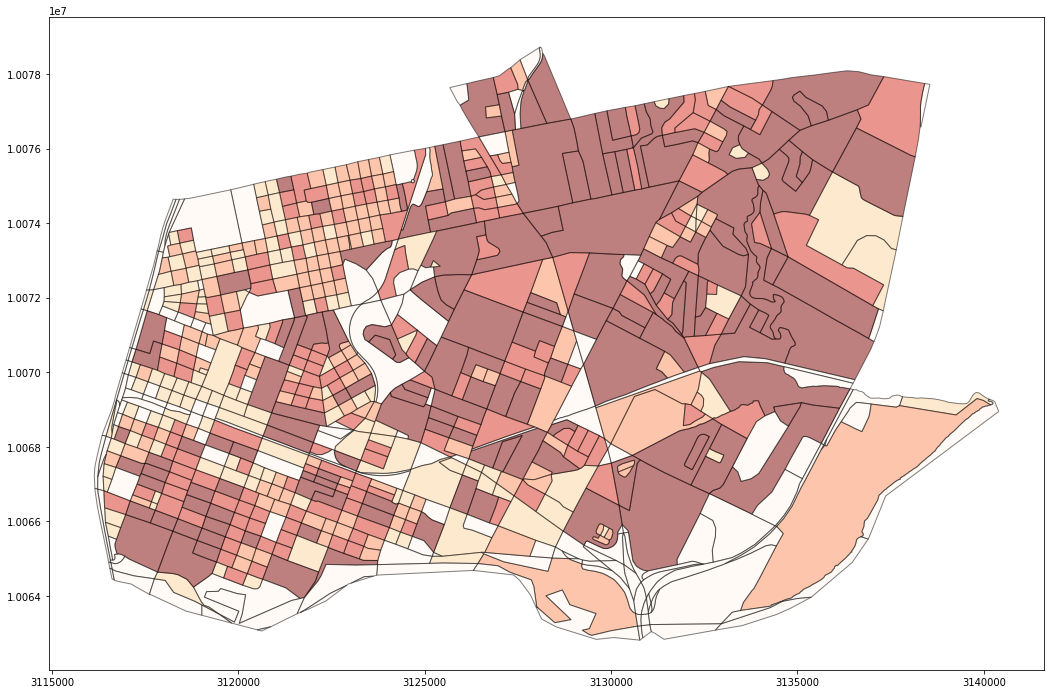

In [31]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_df.plot(ax=ax, column='population', cmap='OrRd', edgecolor='black', alpha=.5, scheme='quantiles')
plt.show()

### Make AoA Boundary (In Ft.)

In [15]:
AoA_geo = makeBoundary(AoA_df)

In [16]:
bounds = AoA_geo.bounds
bounds

,minx,miny,maxx,maxy
0,3.116133e+06,1.006281e+07,3.140396e+06,1.007872e+07


In [17]:
AoA_geo

0    POLYGON ((3121574.560794388 10063520.67102335,...
dtype: object

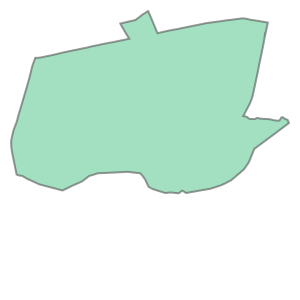

In [18]:
AoA_geo[0]

### Make AoA Boundary (Lat-Long)

In [19]:
AoA_latlong_df = AoA_df.to_crs(LatLongProjection)

In [20]:
AoA_latlong_geo = makeBoundary(AoA_latlong_df)

In [21]:
bounds_latlong = AoA_latlong_geo.bounds
bounds_latlong

,minx,miny,maxx,maxy
0,-97.737298,30.245176,-97.660341,30.289089


In [22]:
AoA_latlong_geo

0    POLYGON ((-97.7226 30.24680799999949, -97.7233...
dtype: object

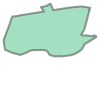

In [23]:
AoA_latlong_geo[0]

## Get Intersections and Road Network Data using AoA Boundary

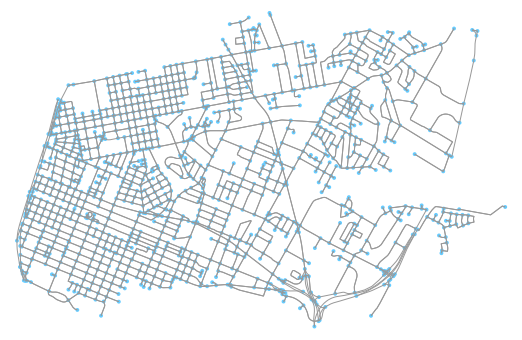

In [24]:
intersections = getIntersections(AoA_latlong_geo[0], NAD83Projection)

Read about [`clean_intersections()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=clean_intersections) 

*note: distances are in meters

In [25]:
type(intersections)

geopandas.geoseries.GeoSeries

In [26]:
intersections.head()

0     POINT (3130804.345327734 10063238.7659741)
1     POINT (3131315.56998964 10064201.14206027)
2    POINT (3131025.934527216 10063525.66121256)
3     POINT (3118788.757601531 10064234.6072428)
4    POINT (3130248.937627049 10064251.94456208)
dtype: object

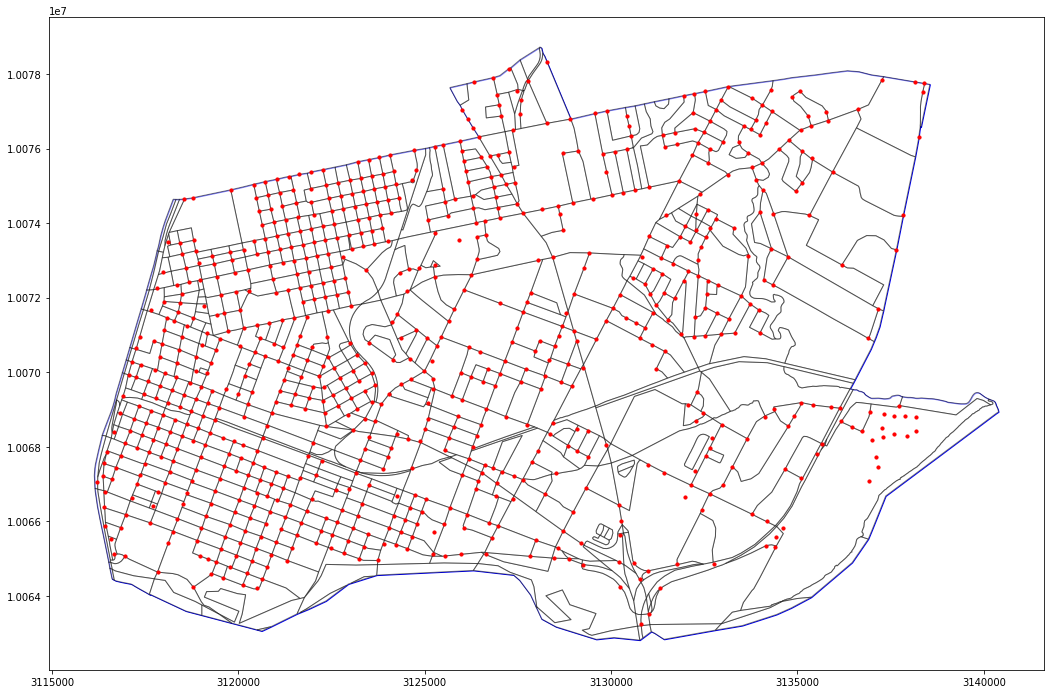

In [27]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections.plot(ax=ax, color='red', markersize=10)
plt.show()

## Calculate Population Metric for each intersection

Find all the census blocks connected to an intersection and sum up their populations. This metric will be the weight assigned to each intersection

In [29]:
AoA_df = IntersectionsPerBlock(AoA_df, intersections)

52 people do not live near an intersection


/home/schmidta/Desktop/schmidtbit/DSI_Capstone/DSI_Project/RouteFinder2.0/Intersections.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  AoA_df['iList'] = iArray
/home/schmidta/Desktop/schmidtbit/DSI_Capstone/DSI_Project/RouteFinder2.0/Intersections.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  AoA_df['iCounts'] = iCounts


In [30]:
AoA_df.head()

,geometry,population,state,county,tract,block,iList,iCounts
ID,,,,,,,,
484530008011000,"POLYGON ((3128165.889933975 10073028.87313997,...",26,48,453,000801,1000,"[POINT (3128691.665435218 10071228.92042302), ...",7
484530008011001,"POLYGON ((3126259.905515095 10072617.07469161,...",54,48,453,000801,1001,"[POINT (3128043.650835329 10073014.5547147), P...",9
484530008011002,"POLYGON ((3128786.624250126 10071485.82559277,...",0,48,453,000801,1002,"[POINT (3128998.797111729 10071103.43538476), ...",5
484530008011003,"POLYGON ((3127742.862405837 10071878.00454578,...",92,48,453,000801,1003,"[POINT (3128998.797111729 10071103.43538476), ...",7
484530008011004,"POLYGON ((3127842.780881476 10072139.02614147,...",76,48,453,000801,1004,"[POINT (3128691.665435218 10071228.92042302), ...",5
